## Packages

In [10]:
!export HDF5_USE_FILE_LOCKING=FALSE

In [11]:
import numpy as np 
import matplotlib.pyplot as plt
import xarray as xr
import utils_jax as utj
import utils as ut
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
from functools import partial

## Path of the data to be analysed

Old data:

path = '/home/viannazv/notebooks/Data/old_data/'
file_name = 'eNATL60GULFSTREAM-BLB002_y2009m07d01_hr.nc'
data = xr.open_dataset(path+file_name)
print(data)

new data:

In [12]:
path = '/home/viannazv/notebooks/Data/'
file_name = 'eNATL60MEDWEST-BLB002_y2009m07d01'

mode = 'lr' # either 'lr' for low resolution, or 'hr' of high resolution

if mode=='lr':
    down = 10
if mode=='hr':
    down = 2

nameu = file_name + '.1h_sozocrtx.nc'
namev = file_name + '.1h_somecrty.nc'
nameh = file_name + '.1h_sossheig.nc'

u = xr.open_dataset(path+nameu)
v = xr.open_dataset(path+namev)
h = xr.open_dataset(path+nameh)

data = xr.merge((u,v,h),compat='override').isel({'time_counter':slice(0,1),'y':slice(0,u.y.size-u.y.size%down),'x':slice(0,u.x.size-u.x.size%down)})
data = data.coarsen(x=down).mean().coarsen(y=down).mean()

#data.to_netcdf('eNATL60GULFSTREAM-BLB002_' + date + '_' + mode + '.nc')

print(data)

<xarray.Dataset>
Dimensions:              (time_counter: 1, y: 80, x: 88, axis_nbounds: 2)
Coordinates:
    nav_lat              (y, x) float32 0.0 0.0 0.0 0.0 ... 44.36 44.35 33.69
    nav_lon              (y, x) float32 0.0 0.0 0.0 0.0 ... 9.135 9.303 7.183
    time_centered        (time_counter) datetime64[ns] 2009-07-01T00:30:00
  * time_counter         (time_counter) datetime64[ns] 2009-07-01T00:30:00
Dimensions without coordinates: y, x, axis_nbounds
Data variables:
    sozocrtx             (time_counter, y, x) float32 nan nan ... 0.01179 0.0
    time_counter_bounds  (time_counter, axis_nbounds) datetime64[ns] 2009-07-...
    somecrty             (time_counter, y, x) float32 nan nan ... -0.0007065 0.0
    sossheig             (time_counter, y, x) float32 nan nan ... -0.09754 0.0
Attributes: (12/14)
    name:         /scratch/tmp/3735876/eNATL60-BLB002_1h_20090630_20090704_gr...
    description:  ocean U grid variables
    title:        ocean U grid variables
    Conventions:  CF-

## Reading the data

In [13]:
lon = data.nav_lon.values
lat = data.nav_lat.values 
SSH = data.sossheig.values[0,:,:]
u = data.sozocrtx.values[0,:,:]
v = data.somecrty.values[0,:,:]

## Input data

In [14]:
g = 9.81 #[m/s2]
coriolis_factor = 2 * 7.2722e-05 * np.sin(lat * np.pi / 180)
Earth_radius = 6370e3

## Ploting functions

In [24]:
def _plot(ax,var,title):
    ax.set_title(title)
    im = ax.pcolormesh(lon,lat,var,shading='auto',cmap = "jet")
    plt.colorbar(im,ax=ax)

def plot(u,v,ssh):
    fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5))
    ax1.set_ylabel('latitude')
    for ax in (ax1,ax2,ax3):
        ax.set_xlabel('longitude')
    _plot(ax1,u,'Field 1')
    _plot(ax2,v,'Field 2')
    _plot(ax3,ssh,'Field 3')
    return fig

# Computing the geostrophic balance

In [25]:
# Changing the funtions from utils in order to use jax.

@partial(jit, static_argnums=(1))
def von_neuman_euler(field, axis):
    f = jnp.copy(field)
    if axis == 0:
        f = f.at[0,:].set(f.at[1,:].get())
        f = f.at[-1,:].set(f.at[-2,:].get())
    if axis == 1:
        f = f.at[:,0].set(f.at[:,1].get())
        f = f.at[:,-1].set(f.at[:,-2].get())
    return f

@partial(jit, static_argnums=(3))
def derivative(field, lon, lat, axis):
    f = jnp.roll(field, -1, axis=axis) - field
    if axis == 0:
        dx = ( jnp.roll(lat, -1, axis=0) - lat ) * jnp.pi / 180     # in radian
        dx = dx * Earth_radius
    if axis == 1:
        dx = ( jnp.roll(lon, -1, axis=1) - lon ) * jnp.pi / 180     # in radian
        dx = dx * Earth_radius * jnp.cos(lat*np.pi/180)
    f = f / dx
    f = von_neuman_euler(f, axis=axis)
    return f

@jit
def gradient(field, lon, lat):
    fx, fy = derivative(field, lon, lat, axis=1), derivative(field, lon, lat, axis=0)
    return fx, fy

In [26]:
# trying to optimize the von_neuman_euler function.

@jit
def von_neuman_euler_long(field):
    field = field.at[0].set(f.at[1].get())
    field = field.at[-1].set(f.at[-2].get())
    return field

@jit
def vmap_von_neuman_euler_long(field):
    return vmap(von_neuman_euler_test)(field)

@jit
def von_neuman_euler_lat(field):
    field = field
    field = field.at[0].set(f.at[1].get())
    field = field.at[-1].set(f.at[-2].get())
    return field

In [27]:
%timeit gradx_ssh, grady_ssh = gradient(SSH, lon, lat)
%timeit gradx_ssh, grady_ssh = ut.gradient(SSH, lon, lat)

79.5 µs ± 11.6 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
144 µs ± 12.4 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [28]:
gradx_ssh, grady_ssh = gradient(SSH, lon, lat)
gradx_ssh, grady_ssh = ut.gradient(SSH, lon, lat)

In [29]:
u_geos = - g * grady_ssh / coriolis_factor
v_geos =   g * gradx_ssh / coriolis_factor

/tmp/ipykernel_2041/1023185854.py:1: RuntimeWarning: divide by zero encountered in true_divide
  u_geos = - g * grady_ssh / coriolis_factor
/tmp/ipykernel_2041/1023185854.py:1: RuntimeWarning: invalid value encountered in true_divide
  u_geos = - g * grady_ssh / coriolis_factor
/tmp/ipykernel_2041/1023185854.py:2: RuntimeWarning: divide by zero encountered in true_divide
  v_geos =   g * gradx_ssh / coriolis_factor
/tmp/ipykernel_2041/1023185854.py:2: RuntimeWarning: invalid value encountered in true_divide
  v_geos =   g * gradx_ssh / coriolis_factor


## Plotting the data and the geostrophic balance

/tmp/ipykernel_2041/195428151.py:3: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im = ax.pcolormesh(lon,lat,var,shading='auto',cmap = "jet")


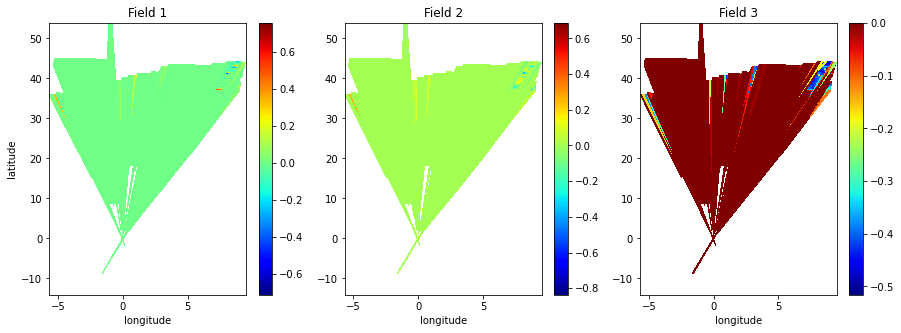

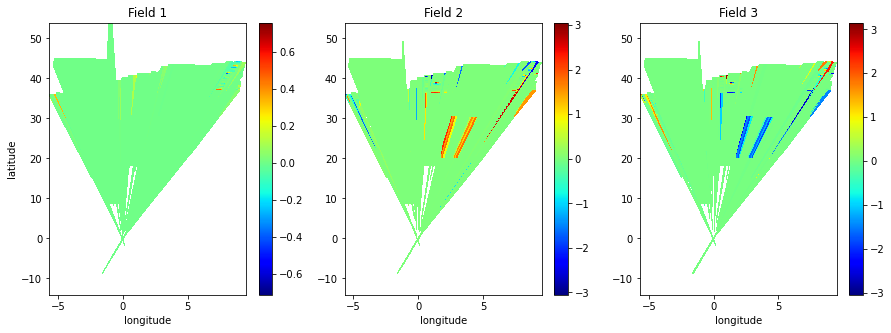

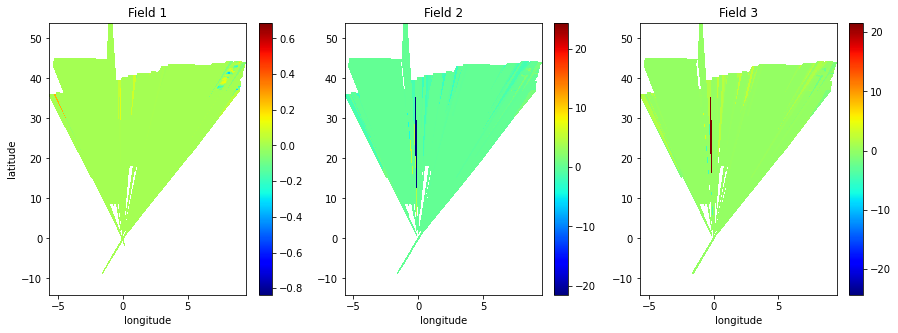

In [30]:
fig = plot(u,v,SSH)
fig = plot(u,u_geos,u - u_geos)
fig = plot(v,v_geos,v - v_geos)

# Computing the cyclogeostrophic balance

The cyclogeostrophic balance can be defined as:

\begin{equation}
    \vec{u} \cdot \nabla \vec{u} + f(\vec{k} \times \vec{u}) = -g \nabla \eta
\end{equation}

For that the advection term $\nabla {\bf u}.{\bf u}$ has to be computed

In [22]:
# trying to optimize the cyclogeostrophic balance functions.

@jit
def advection(u, v, lon, lat):
    #u2, v2, uv = u*u, v*v, u*v
    #adv_u = derivative(u2, lon, lat, axis=1) + derivative(uv, lon, lat, axis=0)
    #adv_v = derivative(uv, lon, lat, axis=1) + derivative(v2, lon, lat, axis=0)
    adv_u = u * derivative(u, lon, lat, axis=1) + v * derivative(u, lon, lat, axis=0)
    adv_v = u * derivative(v, lon, lat, axis=1) + v * derivative(v, lon, lat, axis=0)
    return adv_u, adv_v

@partial(jit, static_argnums=(2,5))
def cyclogeostrophy(ug, vg, coriolis, lon, lat, epsilon):
    """Compute velocities from cyclogeostrophic approximation using the iterative method used in Penven et al. (2014)
    •ug: u component of geostrophic velocity
    •vg: v component of geostrophic velocity
    •coriolis: Coriolis parameter
    •lon: x coordinates (lon)
    •lat: y coordinates (lat)
    •epsilon: residual"""
    u_cg = jnp.copy(ug)
    v_cg = jnp.copy(vg)
    mask = jnp.zeros_like(ug)
    errsq = 1000*jnp.ones_like(ug)
    arreps = epsilon * jnp.ones_like(ug)
    n_iter = 0
    while jnp.any(mask == 0) and n_iter < 100:
        n_iter += 1
        u_n = jnp.copy(u_cg)
        v_n = jnp.copy(v_cg)
        errsq_n = jnp.copy(errsq)
        advec_u, advec_v = advection(u_n,v_n,lon,lat)
        u_np1 = ug - (1/coriolis)*advec_v
        v_np1 = vg + (1/coriolis)*advec_u
        errsq = jnp.square(u_np1-u_n) + jnp.square(v_np1-v_n)
        #print('Iteration process', 'n_iter:', n_iter, 'ug:', u_v[20,25], 'u_cg:', u_cg[20,25], 'errsq_e:', errsq_e[20,25], 'errsq:',errsq[20,25]) 
        mask_np1 = jnp.where(errsq < arreps, 1, 0)
        mask_n = jnp.where(errsq > errsq_n, 1, 0)
        u_cg = mask * u_n + (1-mask) * ( mask_n * u_n + (1-mask_n) * u_np1 )
        v_cg = mask * v_n + (1-mask) * ( mask_n * v_n + (1-mask_n) * v_np1 )
        mask = jnp.maximum(mask, jnp.maximum(mask_n, mask_np1))
        print((n_iter, jnp.where(mask==1)[0].shape, jnp.max(errsq)))
      
        #mask = np.where( (errsq < arreps) | (errsq>errsq_e), 0, 1) # elementwise OR condition
        #errsq = np.where( mask == 0, 0, errsq )
        #maxerr = np.max(errsq)
        #print('mask:',mask[20,25],'errsq_cor:',errsq[20,25],'max_error:',maxerr)
        #print('_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ ')
    return u_cg, v_cg, mask


In [23]:
advec_u,advec_v = advection(u,v,lon,lat)/coriolis_factor

%timeit u_cycl, v_cycl, mask = cyclogeostrophy(u_geos, v_geos, coriolis_factor, lon, lat, 0.0001)

ValueError: Non-hashable static arguments are not supported. An error occurred during a call to 'cyclogeostrophy' while trying to hash an object of type <class 'numpy.ndarray'>, [[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.15147007e-06 6.86914573e-05 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 8.96801339e-06 8.41490910e-05 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.02500351e-04 1.02489117e-04 1.02477803e-04 ... 1.01282632e-04
  1.01265468e-04 1.01248246e-04]
 [1.02712394e-04 1.02701044e-04 1.02689613e-04 ... 1.01482190e-04
  1.01464859e-04 1.01447462e-04]
 [1.02923623e-04 1.02912170e-04 1.02900638e-04 ... 1.01680977e-04
  1.01663441e-04 8.06853277e-05]]. The error was:
TypeError: unhashable type: 'numpy.ndarray'


## Ploting the currents from the geostrophic balance, cyclogestrophic balance and eNAT60

In [ ]:
fig = plot(u_cycl,u_geos,u)
fig = plot(v_cycl,v_geos,v)